# one vs all

In [38]:
import torch_rbf as rbf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Defining an RBF network class

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

class Network(nn.Module):
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return torch.sigmoid(out)
    
    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        self.train()
        obs = x.size(0)
        trainset = MyDataset(x, y)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()

In [87]:
tx = torch.tensor([[fnc[fname](item[1][fname]) for fname in all_feature_names] for item in dataset]).float()
ty = torch.tensor([[item[0][kernel] for kernel in kernels_order] for item in dataset]).float()
tx.shape, ty.shape

(torch.Size([1196, 12]), torch.Size([1196, 25]))

In [113]:
def binary_loss_wrapper(idx):
    def binary_loss(y_pred, y_true):
        y_true_max = torch.max(y_true, axis=1)[0]
        y_true_target = y_true[:, idx]
        y_true_wo_target = torch.max(torch.cat((y_true[:, :idx], y_true[:, idx+1:]), axis=1), axis=1)[0]
        y_true = torch.stack((y_true_wo_target, y_true_target), axis=1)
        weighted_result = y_true_target * y_pred + y_true_wo_target * (1 - y_pred)
        return torch.mean(y_true_max - weighted_result)
    return binary_loss

binary_loss_wrapper(2)(
    torch.tensor([0.7, 0.3, 0.1, 0.6]),
    torch.tensor([
        [0.7, 0.8, 0.9],
        [0.7, 0.8, 0.9],
        [0.7, 0.8, 0.9],
        [0.7, 0.8, 0.9],
    ])
)

tensor(0.0575)

In [114]:
# Instanciating and training an RBF network with the Gaussian basis function
# This network receives a 2-dimensional input, transforms it into a 40-dimensional
# hidden representation with an RBF layer and then transforms that into a
# 1-dimensional output/prediction with a linear layer

# To add more layers, change the layer_widths and layer_centres lists

layer_widths = [12, 1]
layer_centres = [40]
basis_func = rbf.gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, 100, 200, 0.01, binary_loss_wrapper(11))
rbfnet.eval()

Epoch: 100, Progress: 1196/1196, Loss: 0.048424      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [115]:
# Plotting the ideal and learned decision boundaries

with torch.no_grad():
    preds = rbfnet(tx).data.numpy()

preds.shape

(1196, 1)

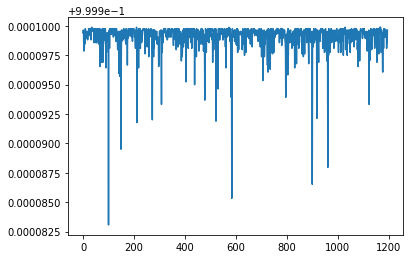

In [116]:
plt.plot(preds)